In [ ]:
! pip install -U sentence-transformers --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import sys
import os
sys.path.append('/content/drive/MyDrive/quora_duplicate_questions/src')

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import log_loss, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sentence_transformers import SentenceTransformer
from utils import clean_text, evaluate_model

from tqdm.auto import tqdm

np.random.seed(7)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load the Data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/quora_duplicate_questions/data/processed'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv.zip'), compression='zip')
val_df = pd.read_csv(os.path.join(DATA_PATH, 'val.csv.zip'), compression='zip')

## Load pre-trained Sentence-BERT Model

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Get Embeddings

In [ ]:
def get_embeddings(df: pd.DataFrame):
    """
    Transform questions to embeddings.

    Args:
        df: DataFrame with 'question1' and 'question2' columns

    Returns:
        Tuple of (question1_embeddings, question2_embeddings)
    """
    q1 = df['question1'].apply(clean_text).fillna("")
    q2 = df['question2'].apply(clean_text).fillna("")

    q1_embeddings = model.encode(q1.tolist(),
                                 show_progress_bar=True,
                                 convert_to_numpy=True,
                                 device=device)
    q2_embeddings = model.encode(q2.tolist(),
                                 show_progress_bar=True,
                                 convert_to_numpy=True,
                                 device=device)

    return q1_embeddings, q2_embeddings

In [ ]:
# Encode both questions
print("Encoding questions from train set...")
q1_train_embeddings, q2_train_embeddings = get_embeddings(train_df)

print("Encoding questions from validation set...")
q1_val_embeddings, q2_val_embeddings = get_embeddings(val_df)
print("Successfully completed!")

Encoding questions from train set...


Batches:   0%|          | 0/8086 [00:00<?, ?it/s]

Batches:   0%|          | 0/8086 [00:00<?, ?it/s]

Encoding questions from validation set...


Batches:   0%|          | 0/2022 [00:00<?, ?it/s]

Batches:   0%|          | 0/2022 [00:00<?, ?it/s]

Successfully completed!


## Calculate Cosine Similarity

In [ ]:
def calculate_cosine_similarities(q1_embeddings: np.ndarray,
                                  q2_embeddings: np.ndarray) -> np.ndarray:
    """
    Calculate cosine similarities between pairs of question embeddings.
    Args:
        q1_embeddings: Embeddings for question1
        q2_embeddings: Embeddings for question2
    Returns:
        Array of cosine similarities
    """
    similarities = [
        cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -1))[0][0]
        for q1, q2 in zip(q1_embeddings, q2_embeddings)
    ]

    return np.array(similarities)

In [ ]:
similarities_train = calculate_cosine_similarities(q1_train_embeddings, q2_train_embeddings)
similarities_val = calculate_cosine_similarities(q1_val_embeddings, q2_val_embeddings)

## Calibrate Similarity into Probabilities with Logistic Regression

In [ ]:
# Cosine similarity is the only feature
X_train = similarities_train.reshape(-1, 1)
y_train = train_df['is_duplicate'].values

X_val = similarities_val.reshape(-1, 1)
y_val = val_df['is_duplicate'].values

# Fit calibration model
calibrator = LogisticRegression(class_weight='balanced')
calibrator.fit(X_train, y_train)

# Predict calibrated probabilities
y_pred_probs_train = calibrator.predict_proba(X_train)
y_pred_probs_val = calibrator.predict_proba(X_val)
y_pred_val = calibrator.predict(X_val)

## Evaluate

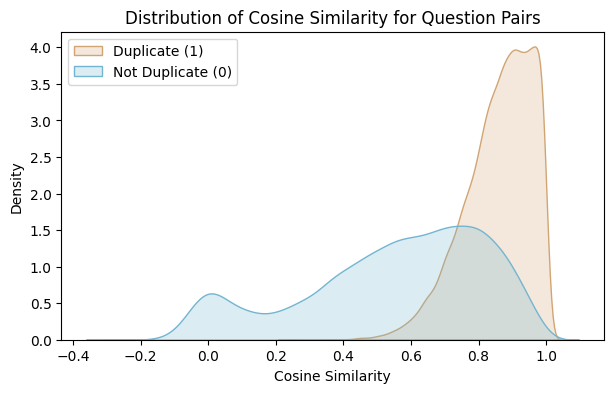

In [ ]:
# Separate scores for the two classes
duplicates = X_val[y_val == 1].flatten()
non_duplicates = X_val[y_val == 0].flatten()

plt.figure(figsize=(7, 4))
sns.kdeplot(duplicates, label='Duplicate (1)', fill=True, color='#D1A573')
sns.kdeplot(non_duplicates, label='Not Duplicate (0)', fill=True, color='#73B5D1')
plt.title('Distribution of Cosine Similarity for Question Pairs')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
log_loss_train, log_loss_val = evaluate_model(
    X_train, X_val, y_train, y_val, calibrator
)

print(f"Log loss on Train set: {log_loss_train:.4f}")
print(f"Log Loss on Validation set: {log_loss_val:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

Log loss on Train set: 0.4431
Log Loss on Validation set: 0.4403

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81     40804
           1       0.65      0.85      0.74     23882

    accuracy                           0.78     64686
   macro avg       0.77      0.79      0.77     64686
weighted avg       0.80      0.78      0.78     64686



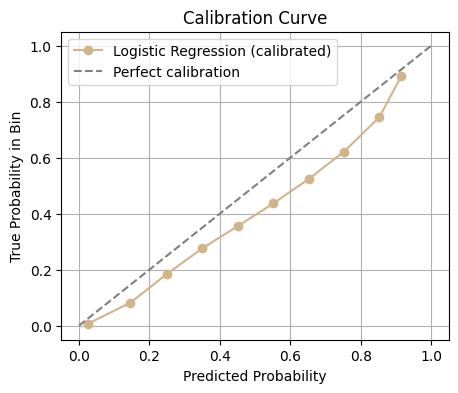

In [ ]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_val, y_pred_probs_val[:, 1], n_bins=10)

plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', color='tan', label='Logistic Regression (calibrated)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

plt.title('Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability in Bin')
plt.legend()
plt.grid(True)
plt.show()

Curve lies below the diagonal: over-confident (predicts higher probabilities than actual).

In [ ]:
experiment_results = joblib.load(os.path.join(DATA_PATH, 'experiment_results.joblib'))

In [ ]:
results = {}
results['model'] = 'SentenceTransformer with Cosine Similarity'
results['log_loss_train'] = np.round(log_loss_train, 5)
results['log_loss_val'] = np.round(log_loss_val, 5)

experiment_results.append(results)

In [ ]:
joblib.dump(experiment_results, os.path.join(DATA_PATH, 'experiment_results.joblib'))

['/content/drive/MyDrive/quora_duplicate_questions/data/processed/experiment_results.joblib']